In [1]:
from pathlib import Path
import os
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnv
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor
from utils import get_data, get_scaled_data, get_time_data, prepare_aligned_data, daily_portfolio_return, statistics_calc
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_env = Path(Path(os.getcwd()).parent, 'data', 'NQH1.csv')
df = pd.read_csv(path_to_env, sep=';')
df.head()

,timestamp,open,high,low,close,volume
0,2020-10-20T01:01:00Z,11702.25,11702.25,11701.00,11701.00,3.0
1,2020-10-20T01:19:00Z,11711.75,11711.75,11711.75,11711.75,1.0
2,2020-10-20T01:28:00Z,11692.00,11692.00,11679.75,11679.75,2.0
3,2020-10-20T01:32:00Z,11670.50,11670.50,11668.00,11668.00,2.0
4,2020-10-20T01:37:00Z,11673.50,11673.50,11672.00,11672.00,3.0


In [9]:
df['timestamp'].min()

'2020-10-20T01:01:00Z'

In [10]:
df['timestamp'].max()

'2021-03-19T00:00:00Z'

In [9]:
path_to_env = Path(Path(os.getcwd()).parent, 'data', 'NQ_1min.csv')
df = pd.read_csv(path_to_env, sep=',', index_col='timestamp', parse_dates=True)
df.head()

,open,high,low,close,volume,price_diff,ret,log_ret,ticker
timestamp,,,,,,,,,
2019-07-23 00:06:00,7953.00,7953.00,7953.00,7953.00,1.0,NaN,NaN,NaN,NQZ9
2019-07-23 00:09:00,7952.00,7952.00,7952.00,7952.00,1.0,-1.00,-0.000126,-0.000126,NQZ9
2019-07-23 00:17:00,7947.75,7947.75,7947.75,7947.75,1.0,-4.25,-0.000534,-0.000535,NQZ9
2019-07-23 00:24:00,7941.75,7941.75,7941.75,7941.75,1.0,-6.00,-0.000755,-0.000755,NQZ9
2019-07-23 00:43:00,7939.25,7939.25,7939.25,7939.25,1.0,-2.50,-0.000315,-0.000315,NQZ9


In [10]:
eqv = df['log_ret'].fillna(0).resample('1D').agg('sum')

In [12]:
len(eqv)

1786

In [16]:
df['timestamp'].min()

'2019-07-23 00:06:00'

In [17]:
df['timestamp'].max()

'2024-06-11 08:15:00'

In [18]:
df.shape

(1674721, 10)

# Тестирование процесса обучения

In [2]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 50,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-07-23", "2023-01-11"),
    "val_period": ("2023-01-11", "2024-06-11"),
    "seed": 42,
    "default_params": {
        "learning_rate": 0.01,
        "buffer_size": 50000,
        "learning_starts": 5000,
        "batch_size": 64,
        "gamma": 0.99,
        "exploration_fraction": 0.1,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

In [3]:
# Фиксация сидов для воспроизводимости
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def create_env(data, scaled_data, time_data, config, mode='train'):
    """Создает окружение с синхронизированными данными"""
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    
    # Создаем маску для выбранного периода
    if mode == 'train':
        mask = (data.index >= train_start) & (data.index <= train_end)
    else:
        mask = (data.index >= val_start) & (data.index <= val_end)
    
    # Применяем маску
    data_segment = data[mask] # исторические данные OLHC
    scaled_segment = scaled_data[mask] # признаковое описание (тех индикаторы и тд)
    time_segment = time_data[mask] # временные признаки
    
    # Проверка согласованности
    assert len(data_segment) == len(scaled_segment) == len(time_segment), \
        f"Размеры не совпадают: data={len(data_segment)}, scaled={len(scaled_segment)}, time={len(time_segment)}"
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    return make_vec_env(
        lambda: StockTradingEnv(**env_kwargs),
        n_envs=1,
        vec_env_cls=DummyVecEnv
    )


# Конфигурация модели
def get_model_config(model_type, trial=None):
    """Возвращает конфигурацию для выбранного типа модели"""
    base_config = {
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [4]:
def train_model(config, trial=None):
    """Обучает модель с заданной конфигурацией"""
    set_seeds(config["seed"])
    
    # Получаем синхронизированные данные
    data_array, scaled_array, time_array, full_index = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения
    env_train = create_env(data_array, scaled_array, time_array, config, 'train')
    env_val = create_env(data_array, scaled_array, time_array, config, 'val')

    params = config["default_params"].copy()

    tb_log = params.pop("tensorboard_log")
    tb_log_path = f"save/{tb_log}/{config['model_type']}_{trial.number if trial else 'default'}"

    if trial:
        params.update({
            "learning_rate": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.999),
            "exploration_fraction": trial.suggest_float("exploration_frac", 0.1, 0.5),
            "buffer_size": trial.suggest_int("buffer_size", 5000, 100000)
        })
    
    model_config = get_model_config(config["model_type"], trial=trial)

    model = DQN(
        "MlpPolicy",
        env_train,
        policy_kwargs=model_config,
        verbose=1,
        tensorboard_log=tb_log_path,
        #replay_buffer_kwargs=dict(optimize_memory_usage=True),
        device="auto",
        **params
    )

    print(model_config)
    model.learn(
        total_timesteps=1500000,
        callback=ProgressBarCallback(),
        log_interval=100,
        tb_log_name=f"{config['model_type']}_{trial.number if trial else 'default'}"
    )
    print('Обучение завершено')
    #sharpe_ratio, returns, b_h_ret = evaluate_daily_sharpe(model, env_val)
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    if not trial:
        save_path = Path("models", f"{config['ticker']}_{config['model_type']}")
        model.save(str(save_path))
    
    metrics = statistics_calc(returns, b_h_ret, plot=True)
    return metrics, returns, b_h_ret, model

def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    return train_model(config, trial)

In [5]:
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    return train_model(config, trial)


In [6]:
set_seeds(CONFIG["seed"])

# простая linear модель с одним признаком

Using cpu device
Logging to save/logs//Linear_default\Linear_default_12


GDGDGDGDG
C:\Users\vshchekotikhin\Desktop\work\RL strategy\RL-for-AT\notebooks\save\models


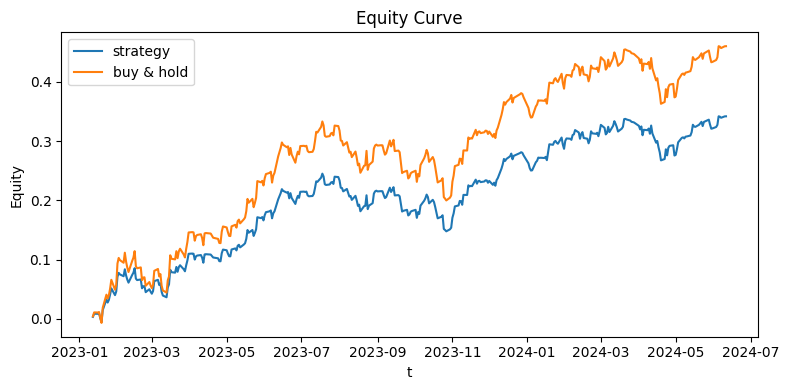

In [7]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)

In [8]:
metrics

,Sharpe ratio,Annual return,Volatility
_,2.278069,0.34099,0.149684


Using cpu device
Logging to save/logs//Linear_default\Linear_default_13


GDGDGDGDG
C:\Users\vshchekotikhin\Desktop\work\RL strategy\RL-for-AT\notebooks\save\models


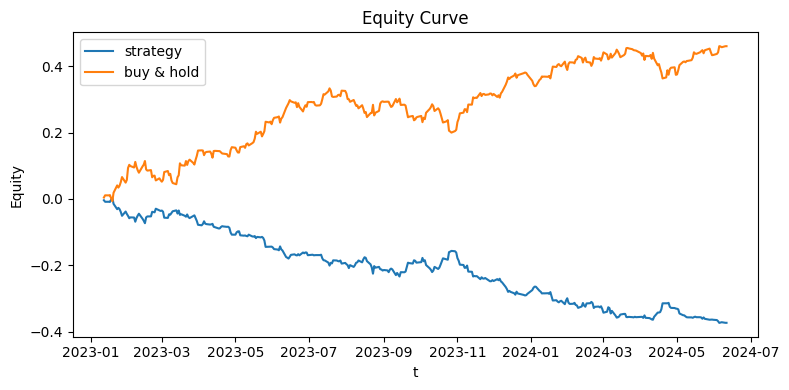

In [7]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)

# Linear модель с иправленными признаками

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_26


GDGDGDGDG
C:\Users\vshchekotikhin\Desktop\work\RL strategy\RL-for-AT\notebooks\save\models


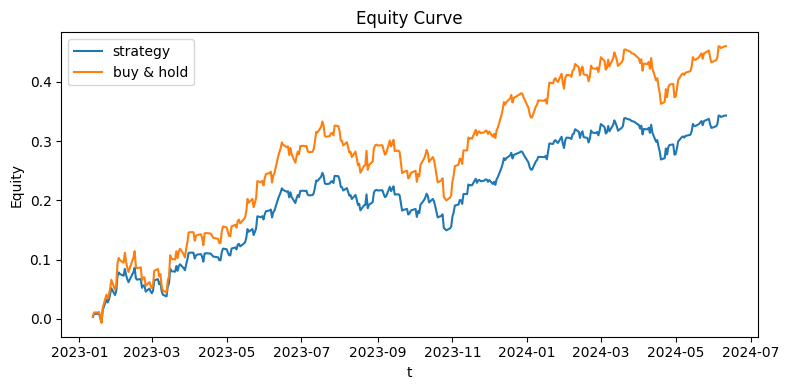

In [14]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)

In [15]:
metrics

,Sharpe ratio,Annual return,Volatility
_,2.285649,0.342319,0.149769


In [7]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 1,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-07-23", "2023-01-11"),
    "val_period": ("2023-01-11", "2024-06-11"),
    "seed": 42,
    "default_params": {
        "learning_rate": 0.01,
        "buffer_size": 50000,
        "learning_starts": 5000,
        "batch_size": 64,
        "gamma": 0.99,
        "exploration_fraction": 0.1,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 1}}
Logging to save/logs//Linear_default\Linear_default_7


Output()

Обучение завершено


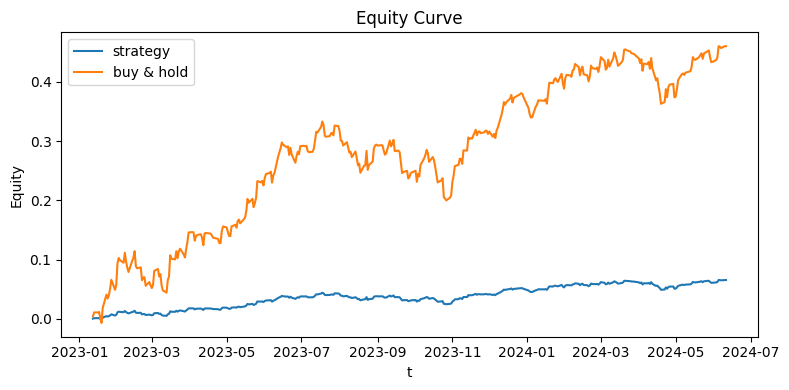

In [8]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur = train_model(CONFIG)

In [9]:
metrics

,Sharpe ratio,Annual return,Volatility
_,2.206249,0.06551,0.029693


In [7]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2023-01-11"),
    "val_period": ("2023-01-11", "2024-06-11"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 1}}
Logging to save/logs//Linear_default\Linear_default_12


Output()

Обучение завершено


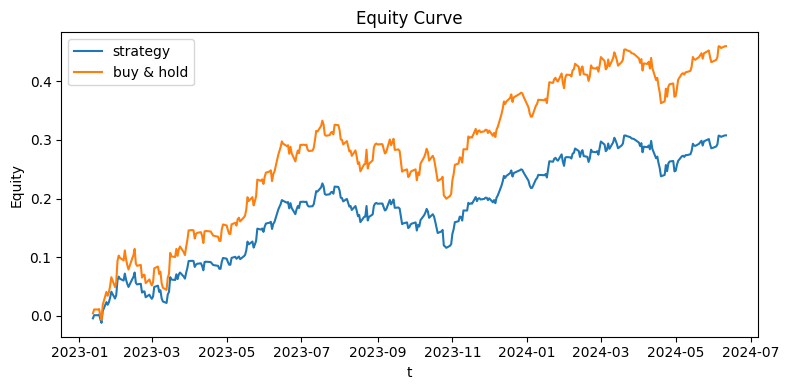

In [13]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

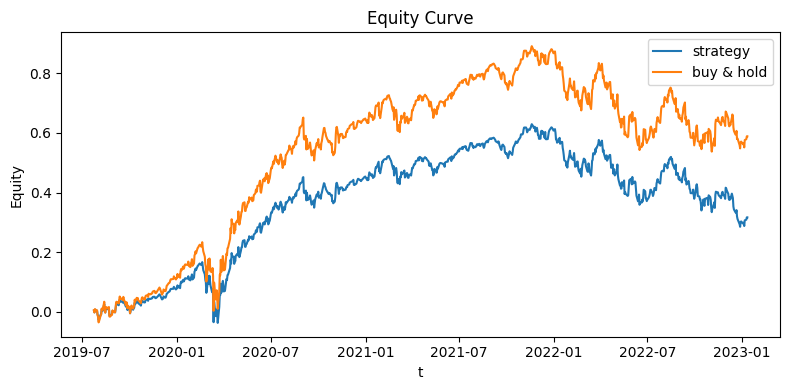

In [17]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [18]:
metrics

,Sharpe ratio,Annual return,Volatility
_,0.521846,0.128692,0.246609


добавил штраф за волатильность в функцию награды 

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 1}}
Logging to save/logs//Linear_default\Linear_default_13


Output()

Обучение завершено


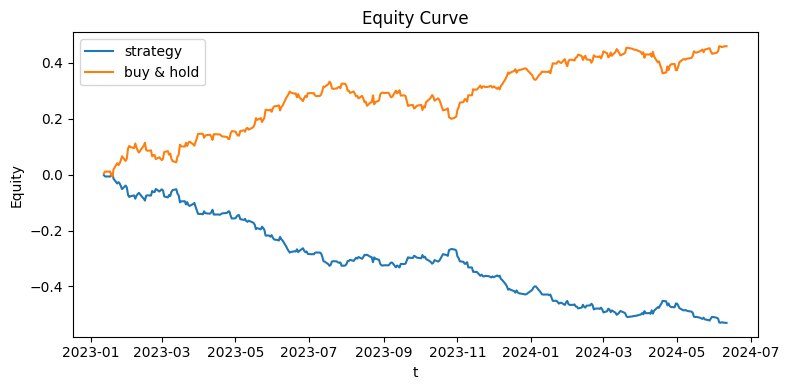

In [8]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [10]:
metrics

,Sharpe ratio,Annual return,Volatility
_,-3.682245,-0.529582,0.14382


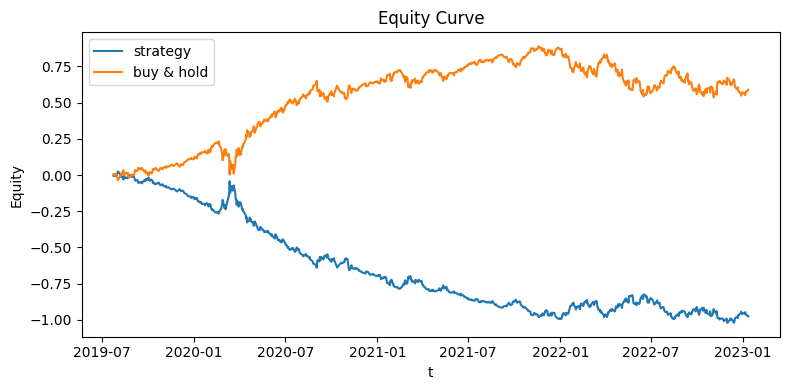

In [11]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [12]:
metrics

,Sharpe ratio,Annual return,Volatility
_,-1.667505,-0.396346,0.237688


# Тест на маленьком окне данных

In [8]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2019-08-11"),
    "val_period": ("2019-08-11", "2019-08-25"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 1}}
Logging to save/logs//Linear_default\Linear_default_14


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | -14.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1172     |
|    time_elapsed     | 222      |
|    total_timesteps  | 260400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.58     |
|    n_updates        | 62599    |
----------------------------------


Обучение завершено


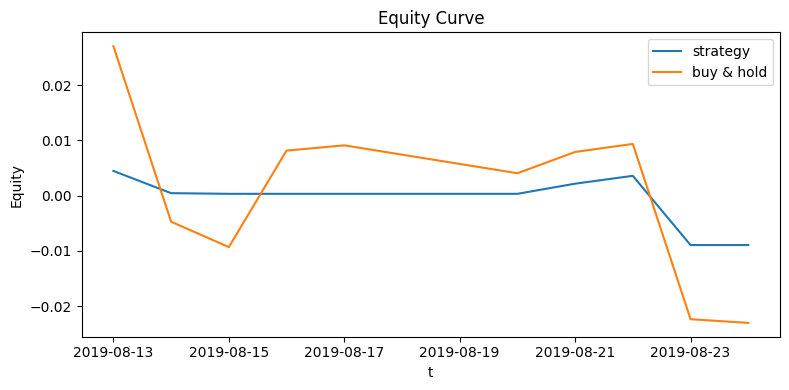

In [9]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [10]:
metrics


,Sharpe ratio,Annual return,Volatility
_,-3.909116,-0.326211,0.083449


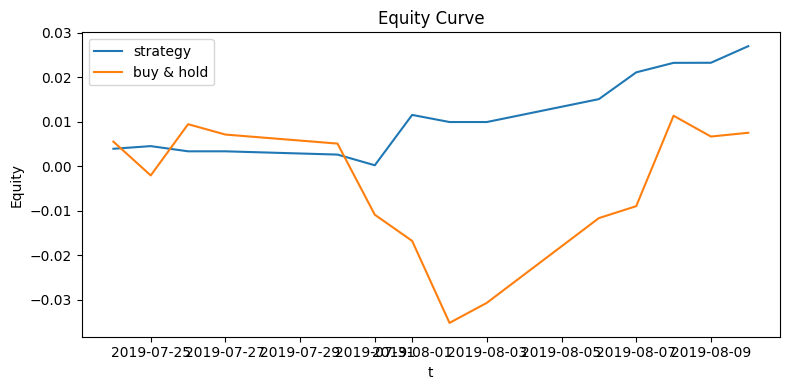

In [11]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [12]:
metrics


,Sharpe ratio,Annual return,Volatility
_,10.183821,0.70372,0.069102


In [18]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2023-01-11"),
    "val_period": ("2023-01-11", "2024-06-11"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_16


Output()

Обучение завершено


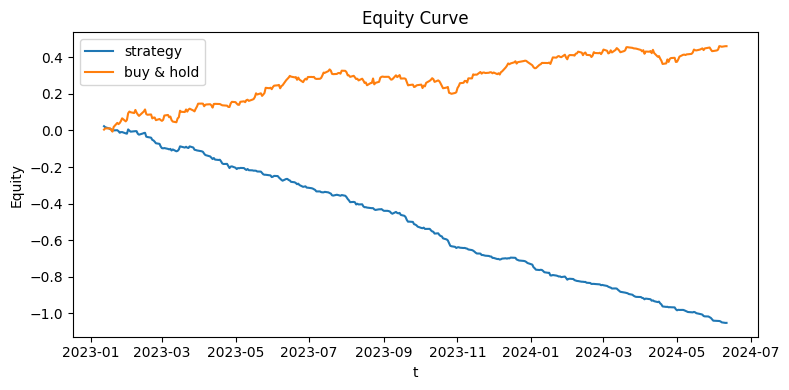

In [19]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [20]:
metrics

,Sharpe ratio,Annual return,Volatility
_,-11.269422,-1.049263,0.093107


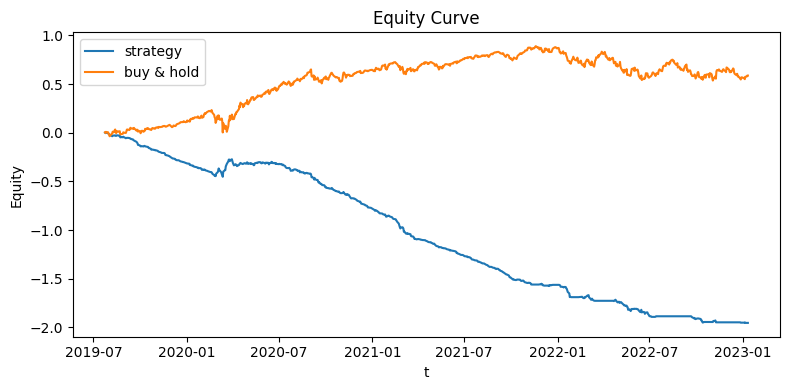

In [21]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [22]:
metrics


,Sharpe ratio,Annual return,Volatility
_,-6.293961,-0.793583,0.126086


In [7]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2019-08-11"),
    "val_period": ("2019-08-11", "2019-08-25"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_19


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 1.39e+03 |
|    exploration_rate | 0.408    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1008     |
|    time_elapsed     | 258      |
|    total_timesteps  | 260400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.86     |
|    n_updates        | 62599    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 3.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 963      |
|    time_elapsed     | 540      |
|    total_timesteps  | 520800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.46     |
|    n_updates      

Обучение завершено


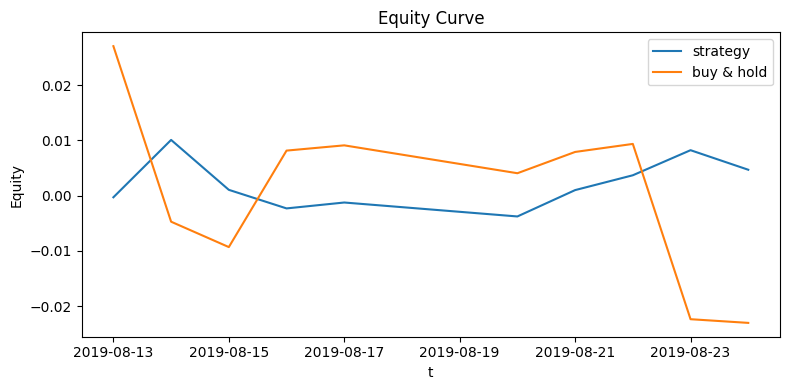

In [8]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [9]:
metrics

,Sharpe ratio,Annual return,Volatility
_,1.730238,0.17155,0.099148


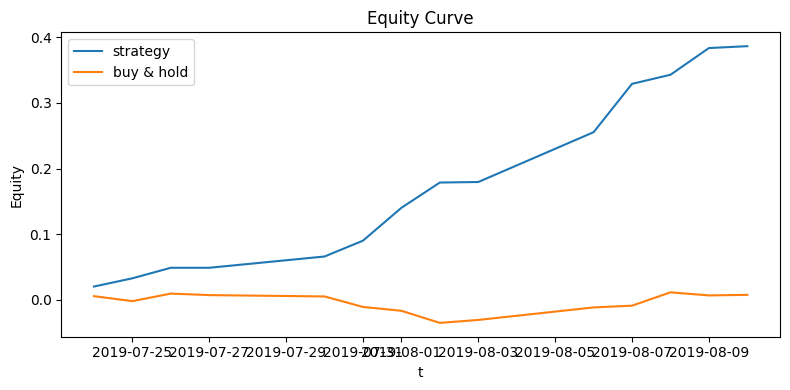

In [10]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [11]:
metrics

,Sharpe ratio,Annual return,Volatility
_,21.975594,10.08043,0.45871
